Automate multiple NS-3 simulation scenarios using Python:

- Number of links

- Link characteristics (data rate, delay)

- Queue types

- App traffic (UDP/TCP, OnOff distribution, etc.)

https://github.com/signetlabdei/sem/blob/master/examples/Propagation%20Samples.ipynb

In [28]:
import sem
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
sns.set_style("whitegrid")
import random
import pandas as pd
import io


When first building it may take on my dev pc 30 mins, but once run it will take 25 seconds

In [17]:
import sem
ns_path = 'ns-3-dev/'
script = 'multi-links-sem'
campaign_dir = 'testResults'
campaign = sem.CampaignManager.new(
    ns_path=ns_path,
    script=script,
    campaign_dir=campaign_dir,
    overwrite=True,
    max_parallel_processes=2
)


In [18]:
print(campaign)

--- Campaign info ---
script: multi-links-sem
params: {'numLinks': 2.0, 'dataRates': '1Mbps,500Kbps', 'delays': '100ms,200ms', 'queueType': 'ns3::FifoQueueDisc', 'queueMaxSize': '100p', 'transportType': 'udp', 'onTimeType': 'Constant', 'onTimeParam': 1.0, 'offTimeType': 'Constant', 'offTimeParam': 0.5, 'appRate': '1Mbps', 'packetSize': 100.0}
HEAD: a17161947b1f4f61bf7705508ce3ec87a499a02b
Runner type: <class 'sem.parallelrunner.ParallelRunner'>
-----------


Try to run this to debug on the shell ./ns3 run "scratch/multi-links-sem --numLinks=2 --dataRates=2Mbps,1Mbps --delays=100ms,200ms"

In [ ]:
    """
    ,
    'queueType':["ns3::FifoQueueDisc"],
    'queueMaxSize': ["10p","50p","100p","500p","1000p"],#list(range(5, 1200,200)),
    'transportType':["udp"],#,"tcp"],
    'onTimeType':["Constant","Exponential"],
    'onTimeParam':["0.8","1.0","1.5","2"],
    'offTimeType':["Constant","Exponential"],
    'offTimeParam':["0.0","0.4","0.5"],
    'appRate':["200Kbps","500Kbps","1Mbps","2Mbps","10Mbps"],
    'packetSize':["512","1000","1400"]
    """

In [19]:
#check the input of the datarates and delays
params = {
    'numLinks':[3], #for now fixed 
    
    'dataRates':["1Mbps,2Mbps,3Mbps","1Mbps,500Kbps,100Kbps","10Mbps,1Mbps,500Kbps"],
    
    'delays': ["100ms,200ms,300ms","300ms,200ms,100ms","1000ms,200ms,500ms","200ms,500ms,1000ms"]


}
runs = 2 #specify how many randomized experiments we want sem to perform for each parameter combination

campaign.run_missing_simulations(params, runs=runs) #this will run 24 experiments

Running simulations: 100%|██████████| 24/24 [00:06<00:00,  3.74simulation/s]


In [57]:
print("There are %s results in the database\n" % len(list(campaign.db.get_complete_results())))
example_result = campaign.db.get_complete_results()[5]
print("This is an example result:\n")
pprint.pprint(example_result)

There are 24 results in the database

This is an example result:

{'meta': {'elapsed_time': 0.4226233959197998,
          'exitcode': 0,
          'id': 'a4459d0d-2ccd-4b8a-b1f6-cd73a9b3c1e6'},
 'output': {'flow_df.csv': 'flow_id,time_first_tx_s,time_first_rx_s,time_last_tx_s,time_last_rx_s,delay_sum_s,jitter_sum_s,last_delay_s,tx_bytes,rx_bytes,tx_packets,rx_packets,lost_packets,times_forwarded,duration,throughput_Mbps,src,dst,src_port,dst_port,protocol,mean_delay,mean-jitter,flow_5tuple\n'
                           '1,1.5008000000000001,1.6018400000000002,9.9992,10.307400000000001,1610.26,2.8772800000000003,0.30824,959872,891520,7499,6965,534,0,8.806600000000001,0.8098653282765197,10.1.1.2,10.1.1.1,49153,9,17,0.23119310839913854,0.000413105527638191,10.1.1.2-10.1.1.1-49153-9-17\n',
            'multi-link-0-1.pcap': 'RAW',
            'multi-link-0-2.pcap': 'RAW',
            'multi-link-0-3.pcap': 'RAW',
            'multi-link-1-1.pcap': 'RAW',
            'multi-link-1-2.pcap': '

In [121]:
"""
@sem.utils.output_labels([
    'flow_id', 'time_first_tx_s', 'time_first_rx_s', 'time_last_tx_s',
    'time_last_rx_s', 'delay_sum_s', 'jitter_sum_s', 'last_delay_s',
    'tx_bytes', 'rx_bytes', 'tx_packets', 'rx_packets', 'lost_packets',
    'times_forwarded', 'duration', 'throughput_Mbps', 'src', 'dst',
    'src_port', 'dst_port', 'protocol', 'mean_delay', 'mean-jitter',
    'flow_5tuple'
])
"""
#@sem.utils.output_labels(['mean-delay-s','mean-jitter-s'])
@sem.utils.output_labels(['mean-delay-s'])
def getDelay_flows(result):
    string_df = result['output']['stdout']
    df = pd.read_csv(io.StringIO(string_df.strip()))
    #print("DataFrame shape:", df.shape) #debug
    #print("Columns:", df.columns.tolist()) #debug

    #return df.values.tolist()
    #return df[['mean_delay','mean-jitter']].iloc[0].values
    return df['mean_delay'].iloc[0]

@sem.utils.output_labels(['jitter-delay-s'])
def getJitter_flows(result):
    string_df = result['output']['stdout']
    df = pd.read_csv(io.StringIO(string_df.strip()))
    #print("DataFrame shape:", df.shape) #debug
    #print("Columns:", df.columns.tolist()) #debug

    #return df.values.tolist()
    #return df[['mean_delay','mean-jitter']].iloc[0].values
    return df['mean-jitter'].iloc[0]



In [122]:
getDelay_flows(example_result),getJitter_flows(example_result)

(0.2311931083991385, 0.0004131055276381)

In [126]:
# Use the parsing function to create a Pandas dataframe
results_delay = campaign.get_results_as_dataframe(getDelay_flows, params=params)
results_jitter = campaign.get_results_as_dataframe(getJitter_flows, params=params)

In [128]:
#display(results_jitter)

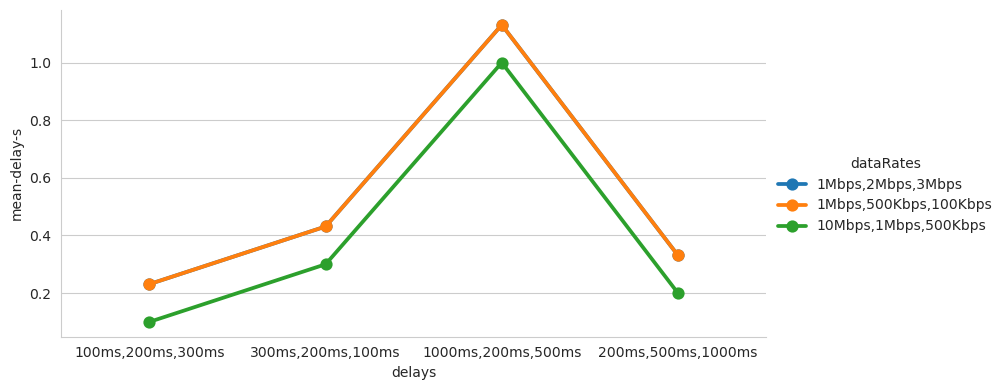

In [ ]:

sns.catplot(data=results_delay,
            x='delays',
            y='mean-delay-s',
            hue='dataRates',
            kind='point',
            height=4,
            aspect=2)  # Width = height * aspect, so 5*2 = 10)
plt.show()

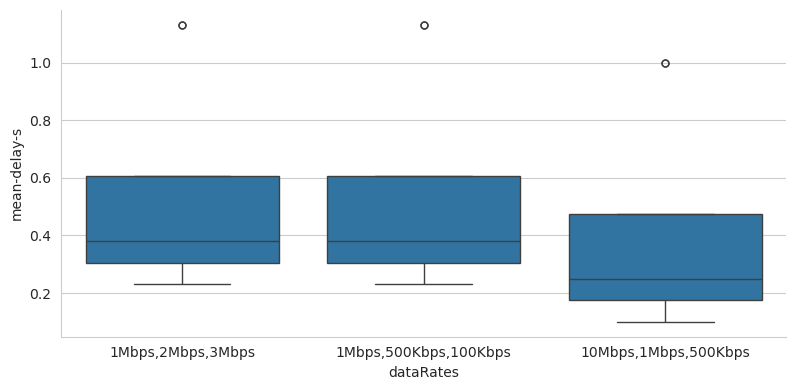

In [ ]:
sns.catplot(data=results_delay,
            x='dataRates',#'delays',
            y='mean-delay-s',
            
            kind='box',
            height=4,
            aspect=2)
plt.show()

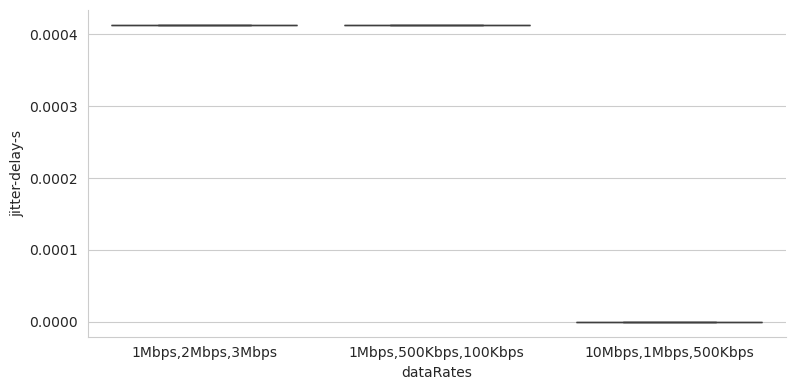

In [134]:
sns.catplot(data=results_jitter,
            x='dataRates',#'delays',
            y='jitter-delay-s',
            
            kind='box',
            height=4,
            aspect=2)
plt.show()

Automate the creation of those functions

In [135]:

feature_columns = [
    'flow_id', 'time_first_tx_s', 'time_first_rx_s', 'time_last_tx_s',
    'time_last_rx_s', 'delay_sum_s', 'jitter_sum_s', 'last_delay_s',
    'tx_bytes', 'rx_bytes', 'tx_packets', 'rx_packets', 'lost_packets',
    'times_forwarded', 'duration', 'throughput_Mbps', 'src', 'dst',
    'src_port', 'dst_port', 'protocol', 'mean_delay', 'mean-jitter',
    'flow_5tuple'
]

# Store dynamically created functions in a dictionary
generated_functions = {}

# Factory to create functions
def make_feature_function(feature_name):
    @sem.utils.output_labels([feature_name])
    def feature_fn(result):
        df = pd.read_csv(io.StringIO(result['output']['stdout'].strip()))
        return df[feature_name].iloc[0]
    return feature_fn

# Create and assign functions dynamically
for col in feature_columns:
    func_name = f"get_{col.replace('-', '_')}_flow"  # handle invalid characters
    generated_functions[func_name] = make_feature_function(col)

# Now you can call e.g.
# value = generated_functions['get_mean_delay_flow'](result)


In [136]:
# Dictionary to store individual results
results_dict = {}

for func_name, func in generated_functions.items():
    print(f"Running: {func_name}")
    df = campaign.get_results_as_dataframe(func, params=params)
    # Store each result using its output label as the key
    # Assumes the function returns a Series or single-column DataFrame
    results_dict[func_name] = df.reset_index(drop=True)


Running: get_flow_id_flow
Running: get_time_first_tx_s_flow
Running: get_time_first_rx_s_flow
Running: get_time_last_tx_s_flow
Running: get_time_last_rx_s_flow
Running: get_delay_sum_s_flow
Running: get_jitter_sum_s_flow
Running: get_last_delay_s_flow
Running: get_tx_bytes_flow
Running: get_rx_bytes_flow
Running: get_tx_packets_flow
Running: get_rx_packets_flow
Running: get_lost_packets_flow
Running: get_times_forwarded_flow
Running: get_duration_flow
Running: get_throughput_Mbps_flow
Running: get_src_flow
Running: get_dst_flow
Running: get_src_port_flow
Running: get_dst_port_flow
Running: get_protocol_flow
Running: get_mean_delay_flow
Running: get_mean_jitter_flow
Running: get_flow_5tuple_flow


In [139]:
from functools import reduce

# Get the list of common columns from the first DataFrame (excluding the feature)
common_cols = results_dict['get_mean_delay_flow'].columns[:-1].tolist()



# Before merging: rename the last column of each df to the feature name (dict key)
renamed_dfs = []
for feature_name, df in results_dict.items():
    feature_col = df.columns[-1]
    df_renamed = df.rename(columns={feature_col: feature_name})
    renamed_dfs.append(df_renamed)

# Merge all DataFrames on the common columns
merged_df = reduce(lambda left, right: pd.merge(left, right, on=common_cols), renamed_dfs)


In [141]:
merged_df.head()

,numLinks,dataRates,delays,offTimeType,onTimeType,offTimeParam,transportType,appRate,queueType,onTimeParam,...,get_duration_flow,get_throughput_Mbps_flow,get_src_flow,get_dst_flow,get_src_port_flow,get_dst_port_flow,get_protocol_flow,get_mean_delay_flow,get_mean_jitter_flow,get_flow_5tuple_flow
0,3,"1Mbps,2Mbps,3Mbps","100ms,200ms,300ms",Constant,Constant,0.5,udp,1Mbps,ns3::FifoQueueDisc,1.0,...,8.8066,0.809865,10.1.1.2,10.1.1.1,49153,9,17,0.231193,0.000413,10.1.1.2-10.1.1.1-49153-9-17
1,3,"1Mbps,2Mbps,3Mbps","100ms,200ms,300ms",Constant,Constant,0.5,udp,1Mbps,ns3::FifoQueueDisc,1.0,...,8.8066,0.809865,10.1.1.2,10.1.1.1,49153,9,17,0.231193,0.000413,10.1.1.2-10.1.1.1-49153-9-17
2,3,"1Mbps,2Mbps,3Mbps","300ms,200ms,100ms",Constant,Constant,0.5,udp,1Mbps,ns3::FifoQueueDisc,1.0,...,9.0066,0.791882,10.1.1.2,10.1.1.1,49153,9,17,0.431193,0.000413,10.1.1.2-10.1.1.1-49153-9-17
3,3,"1Mbps,2Mbps,3Mbps","300ms,200ms,100ms",Constant,Constant,0.5,udp,1Mbps,ns3::FifoQueueDisc,1.0,...,9.0066,0.791882,10.1.1.2,10.1.1.1,49153,9,17,0.431193,0.000413,10.1.1.2-10.1.1.1-49153-9-17
4,3,"1Mbps,2Mbps,3Mbps","1000ms,200ms,500ms",Constant,Constant,0.5,udp,1Mbps,ns3::FifoQueueDisc,1.0,...,9.7066,0.734774,10.1.1.2,10.1.1.1,49153,9,17,1.131193,0.000413,10.1.1.2-10.1.1.1-49153-9-17


Each row = 1 graph

In [143]:
from torch_geometric.data import Data
import torch


In [158]:
#for index, row in merged_df.iterrows(): #iterate over experiments in the merged_df
#    print(row['dataRates'])

In [159]:
node_features = [
    'get_src_flow',         # e.g., 10.1.1.2
    'get_dst_flow',         # e.g., 10.1.1.1
    'get_src_port_flow',    # e.g., 49153
    'get_dst_port_flow',    # e.g., 9
    'get_protocol_flow'     # e.g., 17 (UDP)
]


In [160]:
edge_features = [
    'numLinks',
    'dataRates',              # Must be parsed to numeric
    'delays',                 # Same
    'offTimeParam',
    'onTimeParam',
    'appRate',
    'queueMaxSize',
    'packetSize',
    'RngRun',
    
    # Flow performance metrics
    'get_flow_id_flow',
    'get_time_first_tx_s_flow',
    'get_time_first_rx_s_flow',
    'get_time_last_tx_s_flow',
    'get_time_last_rx_s_flow',
    'get_delay_sum_s_flow',
    'get_jitter_sum_s_flow',
    'get_last_delay_s_flow',
    'get_tx_bytes_flow',
    'get_rx_bytes_flow',
    'get_tx_packets_flow',
    'get_rx_packets_flow',
    'get_lost_packets_flow',
    'get_times_forwarded_flow',
    'get_duration_flow',
    'get_throughput_Mbps_flow',
    'get_mean_delay_flow',
    'get_mean_jitter_flow'
]


Transform each row in your pandas.DataFrame into a torch_geometric.data.Data object

In [151]:

def parse_mbps(s): #converts everything to Mbps
    s = s.strip().lower()
    if 'mbps' in s:
        return float(s.replace('mbps', '').strip())
    elif 'kbps' in s:
        return float(s.replace('kbps', '').strip()) / 1000  # Convert Kbps → Mbps
    else:
        raise ValueError(f"Unrecognized bandwidth format: {s}")


def parse_ms(s):
    return float(s.replace('ms', '').strip())


In [163]:
def row_to_graph(row):
    num_links = row['numLinks']
    
    # Parse edge features
    delays = [parse_ms(d) for d in row['delays'].split(',')]
    rates = [parse_mbps(r) for r in row['dataRates'].split(',')]
    num_edges = len(delays)
        # Step 2: Create edge_index (from node 0 to node 1)
    edge_index = torch.tensor([[0] * num_edges, [1] * num_edges], dtype=torch.long)
    

    # Create edge index: source → hop1 → hop2 → dest
    # Edge index: all edges go from node 0 → node 1
    tx_bytes = float(row['get_tx_bytes_flow'])
    rx_bytes = float(row['get_rx_bytes_flow'])
    duration = float(row['get_duration_flow'])
    edge_attr = torch.tensor([
        [delays[i],rates[i], tx_bytes,rx_bytes,duration]
        for i in range(num_edges)
    ], dtype=torch.float)
   

     
     # Create 2 nodes (src, dst)
    x = torch.tensor([
        [row['get_dst_port_flow'], row['get_protocol_flow']], # Node 0: destination
        [row['get_src_port_flow'], row['get_protocol_flow']]   # Node 1: source
            ], dtype=torch.float)
    
    # Target variables
    y = torch.tensor([row['get_mean_delay_flow'], row['get_throughput_Mbps_flow'], row['get_mean_jitter_flow']], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [164]:
dataset = [row_to_graph(row) for _, row in merged_df.iterrows()]


In [165]:
print(dataset[0])


Data(x=[2, 2], edge_index=[2, 3], edge_attr=[3, 5], y=[3])


In [166]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, edge_in, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(edge_in, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(edge_attr, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Pooling per graph
        x = self.lin(x)
        return x


In [168]:
from torch_geometric.loader import DataLoader

loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = GNN(edge_in=5, hidden_dim=64, out_dim=3)  # 3 outputs: delay, throughput, jitter
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(100):
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()


RuntimeError: The expanded size of the tensor (12) must match the existing size (8) at non-singleton dimension 0.  Target sizes: [12, 64].  Tensor sizes: [8, 1]